## Start by importing the linear model and check the RMSLE:

In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

import statsmodels.api as sm
import warnings
from sklearn.exceptions import DataConversionWarning

#Load our two Data Frames
AmesDummiesOrdinalF = pd.read_csv('AmesDummiesOrdinalF.csv', index_col=0)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [3]:
OriginalList = list(AmesDummiesOrdinalF.columns).remove('SalePrice')

In [4]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesDF = AmesDummiesOrdinalF.copy()

In [5]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesDF2 = AmesDF.copy()
AmesDF = AmesDF.iloc[trainIdxes,]
AmesDFTest = AmesDF2.iloc[testIdxes,]

In [6]:
#Reindex the AmesDF:
AmesDF.index = range(1166)

In [8]:
#Run Linear Regression on the Overall (80%) train set, based on earlier K-fold:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Run the linear regression and check RMSLE:
lm.fit(X, Y)
lmscore = lm.score(X, Y)
lmpredict = lm.predict(X)

#Get scores for the Test set
lmtestscore = lm.score(testX, testY)
lmpredict = lm.predict(testX)

RMSLE = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(lmpredict), 2)))

print("The train R^2 score is: " + str(lmscore))
print("The test R^2 score is: " + str(lmtestscore))
print("The test RMSLE is: " + str(RMSLE))


The train R^2 score is: 0.9066709277906929
The test R^2 score is: 0.8844346308046802
The test RMSLE is: 0.15452269976912938


## Ridge regression:

In [40]:
#Ridge regression

from sklearn.linear_model import Ridge 
from sklearn import preprocessing

ridge_df=AmesDummiesOrdinalF.copy()

SalePrice_r=ridge_df.SalePrice
ridge_df=ridge_df.drop('SalePrice',axis=1)

#Standardize all input columns to 0-1
def standize_df(df,collist):
    for col in collist:
        stan_df=df[[col]]
        min_max_scaler = preprocessing.MinMaxScaler()
        standardized=min_max_scaler.fit_transform(stan_df)
        stan2_df=pd.DataFrame(standardized,columns=stan_df.columns,index=stan_df.index)
        df[[col]]=stan2_df
    return df


collist=list(ridge_df.columns)
ridge_df=standize_df(ridge_df,collist)

#Split to 80%-20% with seed 19
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size= 292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))
rX = ridge_df.iloc[trainIdxes]
rtestX  = ridge_df.iloc[testIdxes]
rY = SalePrice_r.iloc[trainIdxes]
rtestY  = SalePrice_r.iloc[testIdxes]

# with 10 k-fold test, the best lambda=5.129
ridge=Ridge()
ridge.set_params(alpha=5.129)
ridge.fit(rX,rY)
rtrain_score=ridge.score(rX,rY)
rtest_score= ridge.score(rtestX,rtestY)

ridgepredict = ridge.predict(rtestX)
RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(rtestY)-np.log1p(ridgepredict), 2)))


print ('train_score(R2)\t',rtrain_score)
print ('test_score(R2) \t',rtest_score)
print ('Ridge RMSLE \t',RMSLEvalue)

train_score(R2)	 0.8910458134818084
test_score(R2) 	 0.9000437548651089
Ridge RMSLE 	 0.13297401608860263


## Now, import the Random Forest model and check the overall RMSLE:

In [38]:
#Run Random Forest on the Overall (80%) train set, based on earlier K-fold:


#Import RandomForestRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, 
                        n_estimators=200)

#Run the linear regression and check RMSLE:
randomForest.fit(X, Y)
rfscore = randomForest.score(X, Y)
rfpredict = randomForest.predict(X)

#Get scores for the Test set
rftestscore = randomForest.score(testX, testY)
testpredictrf = randomForest.predict(testX)

RMSLErf = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictrf), 2)))

print("The train R^2 score is: " + str(rfscore))
print("The test R^2 score is: " + str(rftestscore))
print("The test RMSLE is: " + str(RMSLErf))

The train R^2 score is: 0.9999964042260657
The test R^2 score is: 0.9087529329594458
The test RMSLE is: 0.12917438327024008


## Now, import the Gradient Boost model and check the overall RMSLE:

In [14]:
#Run Gradient Boost on the Overall (80%) train set, based on earlier K-fold:

#Import GradientBoostRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
gradientBoost = ensemble.GradientBoostingRegressor()
gradientBoost.set_params(n_estimators=800, min_samples_split=4, min_samples_leaf=4, max_features='log2', max_depth=2,
                         loss='huber')

#Run the linear regression and check RMSLE:
gradientBoost.fit(X, Y)
gbscore = gradientBoost.score(X, Y)
gbpredict = gradientBoost.predict(X)

#Get scores for the Test set
gbtestscore = gradientBoost.score(testX, testY)
testpredictgb = gradientBoost.predict(testX)

RMSLEgb = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictgb), 2)))

print("The train R^2 score is: " + str(gbscore))
print("The test R^2 score is: " + str(gbtestscore))
print("The test RMSLE is: " + str(RMSLEgb))

The train R^2 score is: 0.9735706534322098
The test R^2 score is: 0.9280300025444657
The test RMSLE is: 0.11508652020560396


In [57]:
#Run XGBoost on the Overall (80%) train set, based on earlier K-fold:

#Import GradientBoostRegressor and set parameters to those found in the hyperparameter testing:
from xgboost import XGBRegressor
xgBoost = XGBRegressor()
xgBoost.set_params(n_estimators=800, min_samples_split=6, min_samples_leaf=4, 
                   max_depth = 2, loss='huber', colsample_bytree=0.5)

#Run the linear regression and check RMSLE:
xgBoost.fit(X, Y)
xgbscore = xgBoost.score(X, Y)
xgbpredict = xgBoost.predict(X)

#Get scores for the Test set
xgbtestscore = xgBoost.score(testX, testY)
testpredictxgb = xgBoost.predict(testX)

RMSLExgb = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictxgb), 2)))

print("The train R^2 score is: " + str(xgbscore))
print("The test R^2 score is: " + str(xgbtestscore))
print("The test RMSLE is: " + str(RMSLExgb))

The train R^2 score is: 0.9847984670929539
The test R^2 score is: 0.9233748816250845
The test RMSLE is: 0.11590170825595625


## Combine (stack) these results to generate a prediction for SalePrice and see if it outperforms the gradient boosting prediction

In [58]:
stackedpredict = (testpredictgb + testpredictxgb + testpredictrf + lmpredict + ridgepredict)/5
RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
print("The balanced stacked-model RMSLE is: " + str(RMSLEstacked))

The balanced stacked-model RMSLE is: 0.11235297237908207


In [59]:
XGBoostPct = []
GradientPct = []
LinearPct = []
BoostPct = []
RidgePct = []
RMSLE = []
for i in list(range(25)):

    for j in list(range(25)):

        for k in list(range(25)):
            
            for l in list(range(25)):
                
                for m in list(range(25)):
            
                    if (i + j + k + l + m) != 25:
                        continue
                    GradientPct.append(i)
                    LinearPct.append(k)
                    BoostPct.append(j)
                    RidgePct.append(l)
                    XGBoostPct.append(m)


                    stackedpredict = (i*testpredictgb + j*testpredictrf + k*lmpredict + l*ridgepredict + m*testpredictxgb)/25
                    RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
                    RMSLE.append(RMSLEstacked)
                    #print("gradient %: " + str(i) + ", randomforest%: " + str(j) + ", linear%: " + str(k) + ", XGboost%: " + str(m) + ", RMSLE= " + str(RMSLEstacked))
    

In [60]:
Gradient = 5*pd.Series(GradientPct)
Linear = 5*pd.Series(LinearPct)
RandomForest = 5*pd.Series(BoostPct)
Ridge = 5*pd.Series(RidgePct)
XGBoost = 5*pd.Series(XGBoostPct)

RMSLESeries = pd.Series(RMSLE)

StackGridSearchDF = pd.DataFrame({'LinearPct':Linear, 'RidgePct':Ridge, 'RForestPct':RandomForest, 
                                  'GBoostPct':Gradient, 'XGBoostPct': XGBoost,'RMSLE':RMSLESeries})

In [61]:
StackGridSearchDF.sort_values(by='RMSLE', axis=0, ascending=False).head()

,LinearPct,RidgePct,RForestPct,GBoostPct,XGBoostPct,RMSLE
347,120,5,0,0,0,0.152541
345,115,10,0,0,0,0.150671
346,120,0,0,0,5,0.150654
3596,120,0,0,5,0,0.150477
672,120,0,5,0,0,0.149121


In [62]:
StackGridSearchDF.sort_values(by='RMSLE', axis=0).head()

,LinearPct,RidgePct,RForestPct,GBoostPct,XGBoostPct,RMSLE
19557,25,0,25,45,30,0.110878
20446,25,0,25,50,25,0.110881
20366,20,5,20,50,30,0.110899
19550,20,5,25,45,30,0.110899
18502,25,0,25,40,35,0.110904


In [29]:
#For simplicity, we would propose 25% linear, 25%RF, 50%GB
stackedpredict = (3.5*gradientBoost.predict(testX) + 3*xgBoost.predict(testX)+ 1.5*randomForest.predict(testX) 
                  + 2*lm.predict(testX))/10

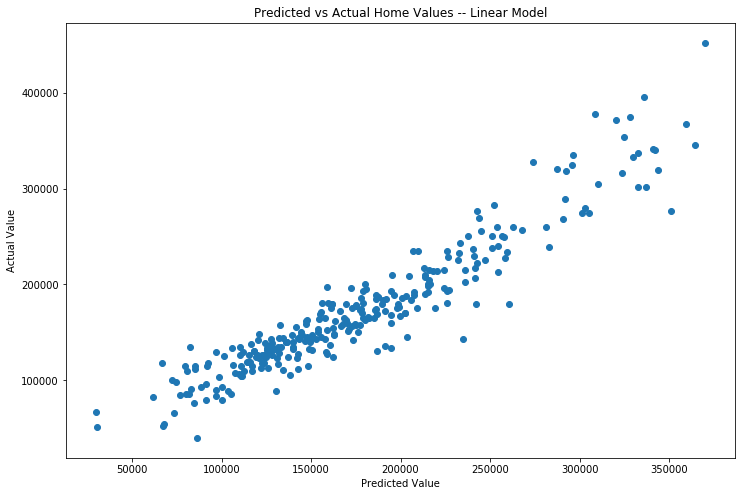

<Figure size 432x288 with 0 Axes>

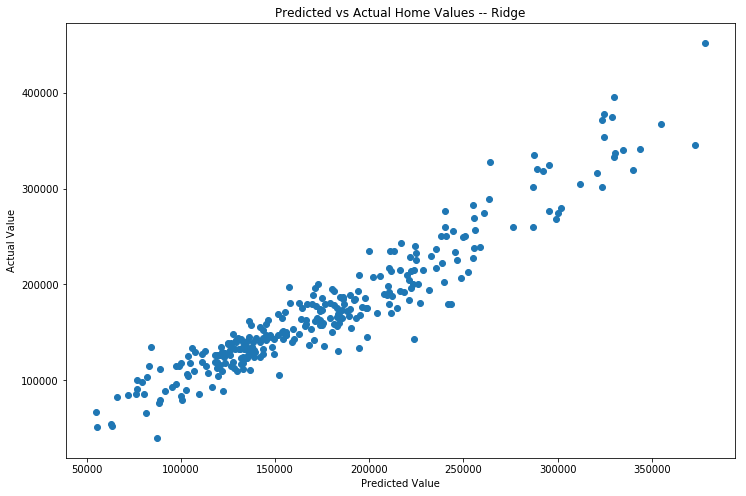

<Figure size 432x288 with 0 Axes>

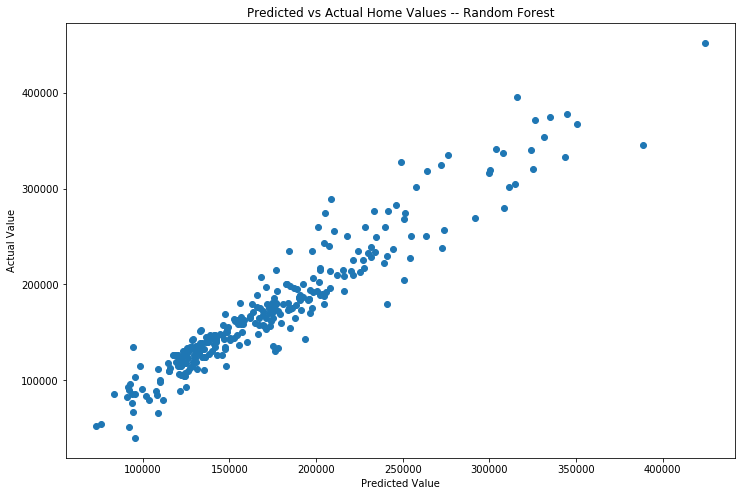

<Figure size 432x288 with 0 Axes>

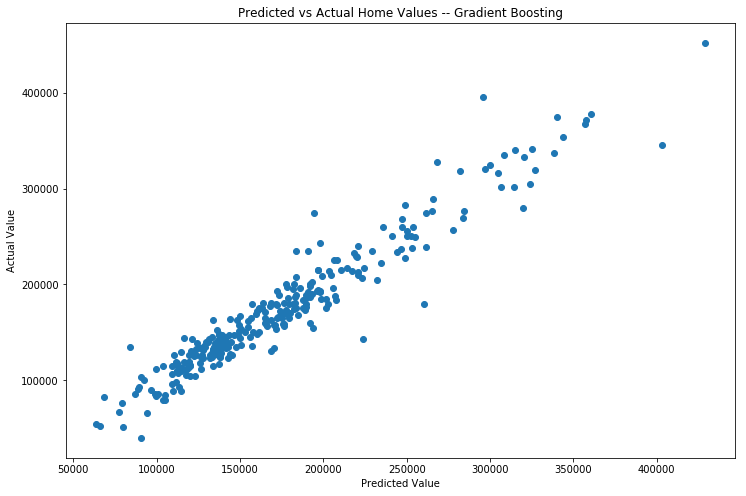

<Figure size 432x288 with 0 Axes>

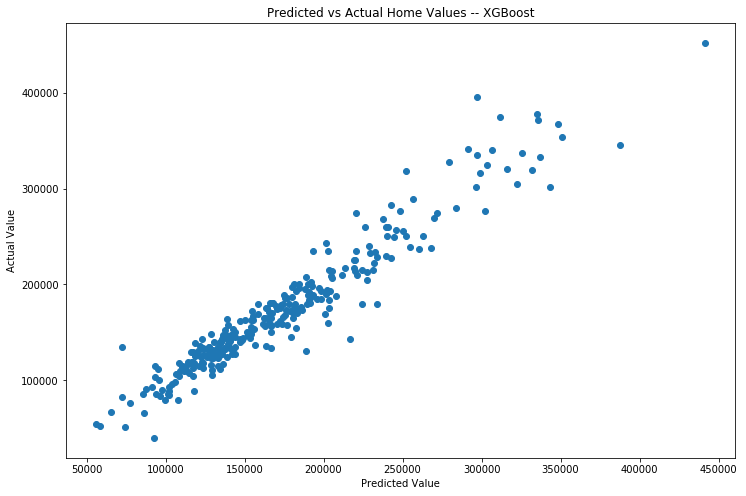

<Figure size 432x288 with 0 Axes>

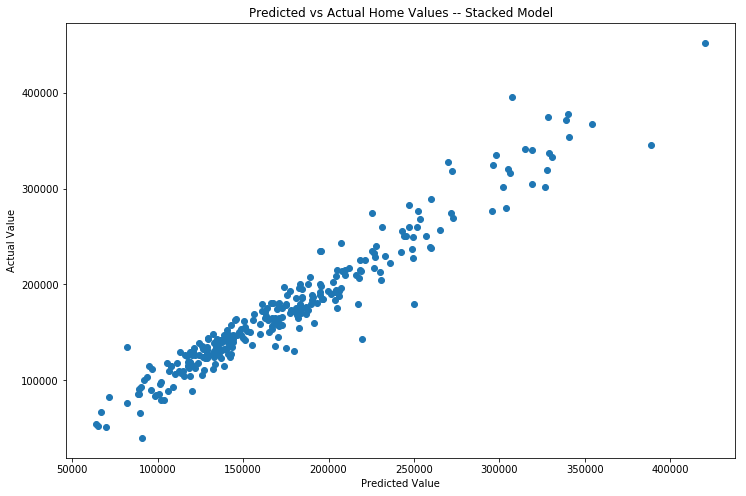

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt

for tup in [('Linear Model', lmpredict), ('Ridge', ridgepredict), ('Random Forest', testpredictrf), ('Gradient Boosting', testpredictgb), ('XGBoost', testpredictxgb), ('Stacked Model', stackedpredict)]:

    plt.figure(figsize=(12,8))
    plt.scatter(tup[1], testY)
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('Predicted vs Actual Home Values -- ' + tup[0])   
    plt.show()
    plt.savefig('PredvActual.png')